**一、載入套件**

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

中文字體

In [2]:
# @title
# 補colab中文字體
!apt-get update -y
!apt-get install -y fonts-noto-cjk

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,759 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,008 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [3]:
# @title
# 指定字體檔路徑
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path, size=14)

**二、連接雲端**

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/監督式kidneyDisease/kidney_disease.csv'
df = pd.read_csv(file_path)

**三、資料處理**

In [6]:
# 去掉欄位名稱的前後空白
df.columns = df.columns.str.strip()

# 看每欄缺失值數量
print(df.isnull().sum())

# 處理 target 欄
target_col = 'Chronic Kidney Disease: yes'
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

# 數值化 + 補值
df = df.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtype == 'object' else col) #欄位->數字
df.fillna(df.mean(numeric_only=True), inplace=True)

Age (yrs)                         0
Blood Pressure (mm/Hg)            0
Specific Gravity                  0
Albumin                           0
Sugar                             0
Blood Glucose Random (mgs/dL)     0
Blood Urea (mgs/dL)               0
Serum Creatinine (mgs/dL)         0
Sodium (mEq/L)                    0
Potassium (mEq/L)                 0
Hemoglobin (gms)                  0
Packed Cell Volume                0
White Blood Cells (cells/cmm)     0
Red Blood Cells (millions/cmm)    0
Red Blood Cells: normal           0
Pus Cells: normal                 0
Pus Cell Clumps: present          0
Bacteria: present                 0
Hypertension: yes                 0
Diabetes Mellitus: yes            0
Coronary Artery Disease: yes      0
Appetite: poor                    0
Pedal Edema: yes                  0
Anemia: yes                       0
Chronic Kidney Disease: yes       0
dtype: int64


**四、模型資料輸入**

In [7]:
# 特徵/標籤
X = df.drop(columns=[target_col])
y = df[target_col]

# 資料切分（加入 stratify）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**決策樹層數判斷**

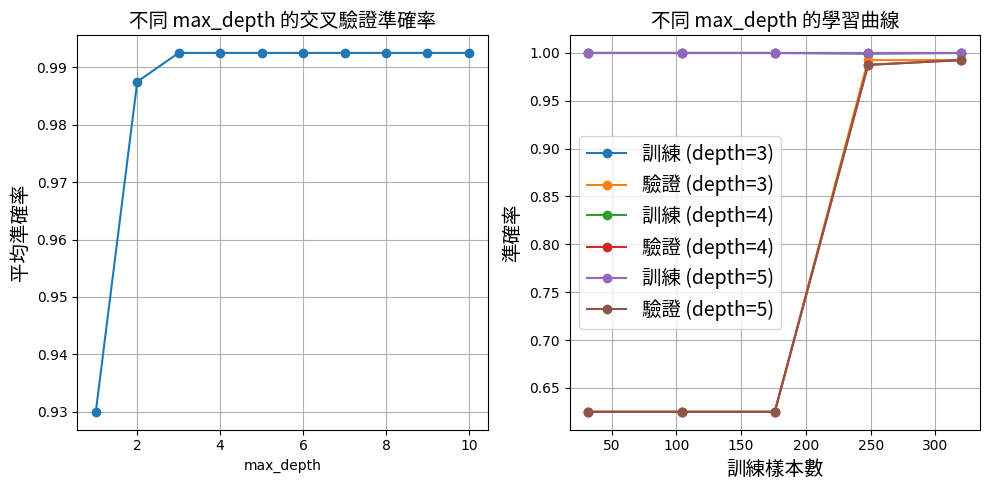

In [8]:
# 測試的樹深度範圍
depth_range = range(1, 11)
cv_scores = []

# 測試不同深度的模型表現 (使用處理後的實際資料 X 和 y)
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# 繪製不同深度的交叉驗證分數
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(depth_range, cv_scores, marker='o')
plt.title("不同 max_depth 的交叉驗證準確率", fontproperties=font_prop)
plt.xlabel("max_depth")
plt.ylabel("平均準確率", fontproperties=font_prop)
plt.grid(True)

# 繪製不同 max_depth 的學習曲線
plt.subplot(1, 2, 2)
for depth in [3, 4, 5]:  # 選擇幾個你感興趣的深度進行比較
    train_sizes, train_scores, test_scores = learning_curve(
        DecisionTreeClassifier(max_depth=depth, random_state=42),
        X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label=f"訓練 (depth={depth})")
    plt.plot(train_sizes, test_scores_mean, 'o-', label=f"驗證 (depth={depth})")

plt.title("不同 max_depth 的學習曲線", fontproperties=font_prop)
plt.xlabel("訓練樣本數", fontproperties=font_prop)
plt.ylabel("準確率", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)

plt.tight_layout()
plt.show()

**五、建立模型**

In [9]:
# 模型建構
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

roc_data = {}
accuracies = {}
# 訓練一棵決策樹
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
# 模型訓練 + 評估
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    accuracies[name] = acc
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}

#建立與訓練模型
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**六、取得資料特徵重要性（發現權重過半欄位則回到三、刪除該欄位） **


📊 特徵重要性與佔比：
                                特徵       重要性     佔比 (%)
0                 Hemoglobin (gms)  0.762735  76.273471
1                 Specific Gravity  0.171692  17.169196
2               Packed Cell Volume  0.039355   3.935484
3                          Albumin  0.026218   2.621849
4                            Sugar  0.000000   0.000000
5    Blood Glucose Random (mgs/dL)  0.000000   0.000000
6           Blood Pressure (mm/Hg)  0.000000   0.000000
7                        Age (yrs)  0.000000   0.000000
8        Serum Creatinine (mgs/dL)  0.000000   0.000000
9              Blood Urea (mgs/dL)  0.000000   0.000000
10               Potassium (mEq/L)  0.000000   0.000000
11                  Sodium (mEq/L)  0.000000   0.000000
12   White Blood Cells (cells/cmm)  0.000000   0.000000
13  Red Blood Cells (millions/cmm)  0.000000   0.000000
14         Red Blood Cells: normal  0.000000   0.000000
15               Pus Cells: normal  0.000000   0.000000
16        Pus Cell Clumps: present 

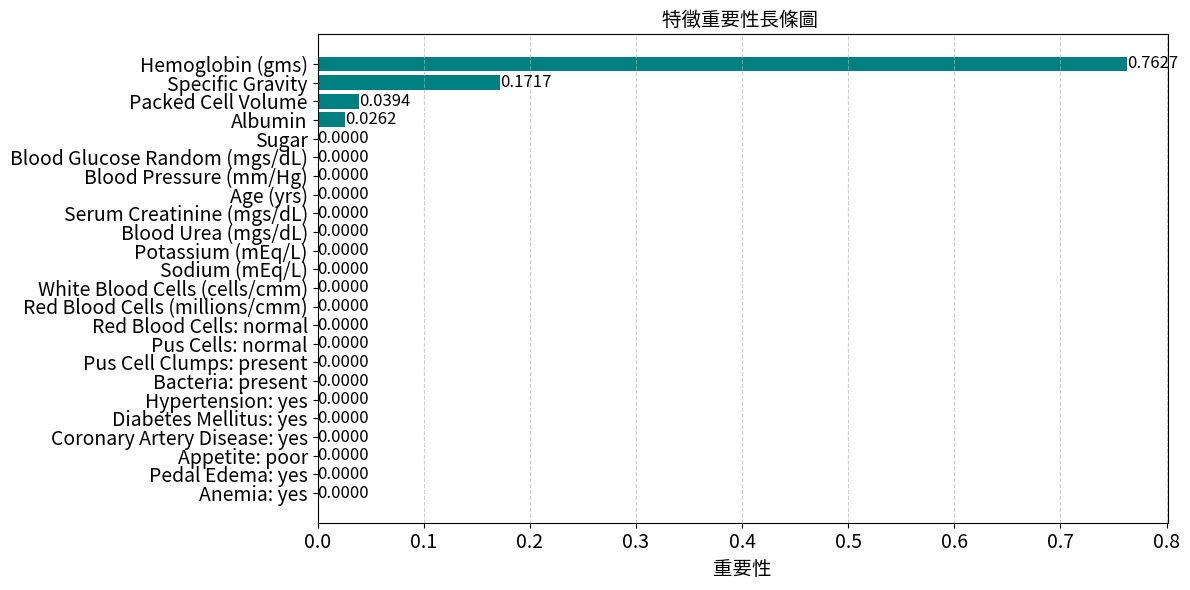

In [10]:
# 取得特徵重要性
feature_importances = model.feature_importances_

# 整理成 DataFrame, 使用 X_dropped.columns 來確保長度一致
importance_df = pd.DataFrame({
    '特徵':  X.columns,  # 改用 X_dropped.columns，與 feature_importances 長度一致
    '重要性': feature_importances
})

# 排序
importance_df = importance_df.sort_values(by='重要性', ascending=False).reset_index(drop=True)

# 計算總重要性佔比
total_importance = importance_df['重要性'].sum()
importance_df['佔比 (%)'] = (importance_df['重要性'] / total_importance) * 100

# 顯示結果
print("\n📊 特徵重要性與佔比：")
print(importance_df)

# 去除前兩名 (如果需要)
# importance_df = importance_df.iloc[2:].reset_index(drop=True)

# 畫長條圖
plt.figure(figsize=(12, 6))
bars = plt.barh(importance_df['特徵'], importance_df['重要性'], color='teal')

# 標上標題跟X軸文字
plt.xlabel('重要性',fontproperties=font_prop)
plt.title('特徵重要性長條圖 ', fontproperties=font_prop)

# 反過來顯示，最大在上面
plt.gca().invert_yaxis()

# 加上橫線
plt.grid(axis='x', linestyle='--', alpha=0.6)

# 每個長條旁邊加上數值
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.4f}',  # 小數點後四位
             va='center', ha='left', fontproperties=font_prop, fontsize=12)

# 設定中文字型
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

# 讓圖不會跑掉
plt.tight_layout()

# 顯示圖
plt.show()

**七、畫圖**

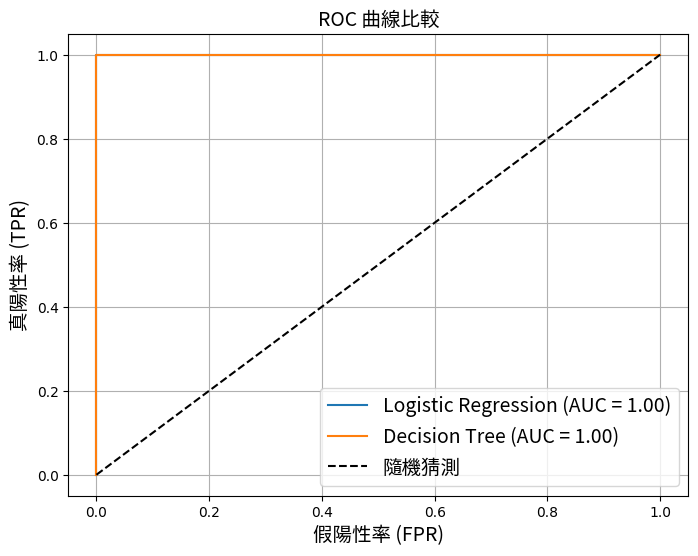

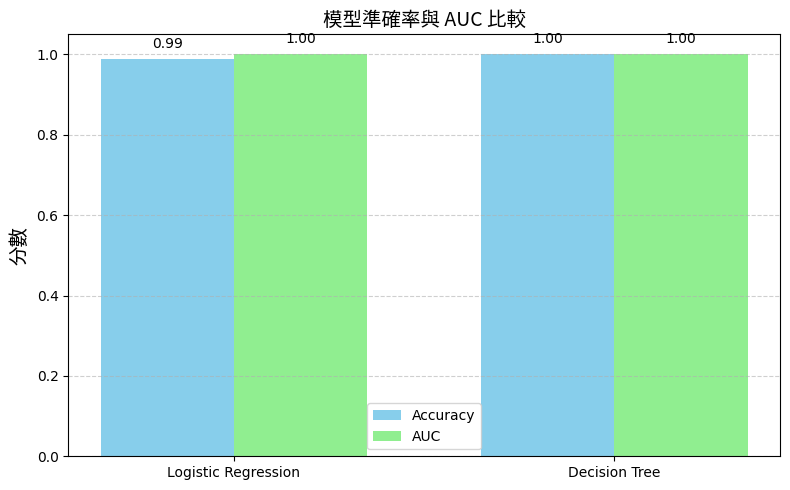

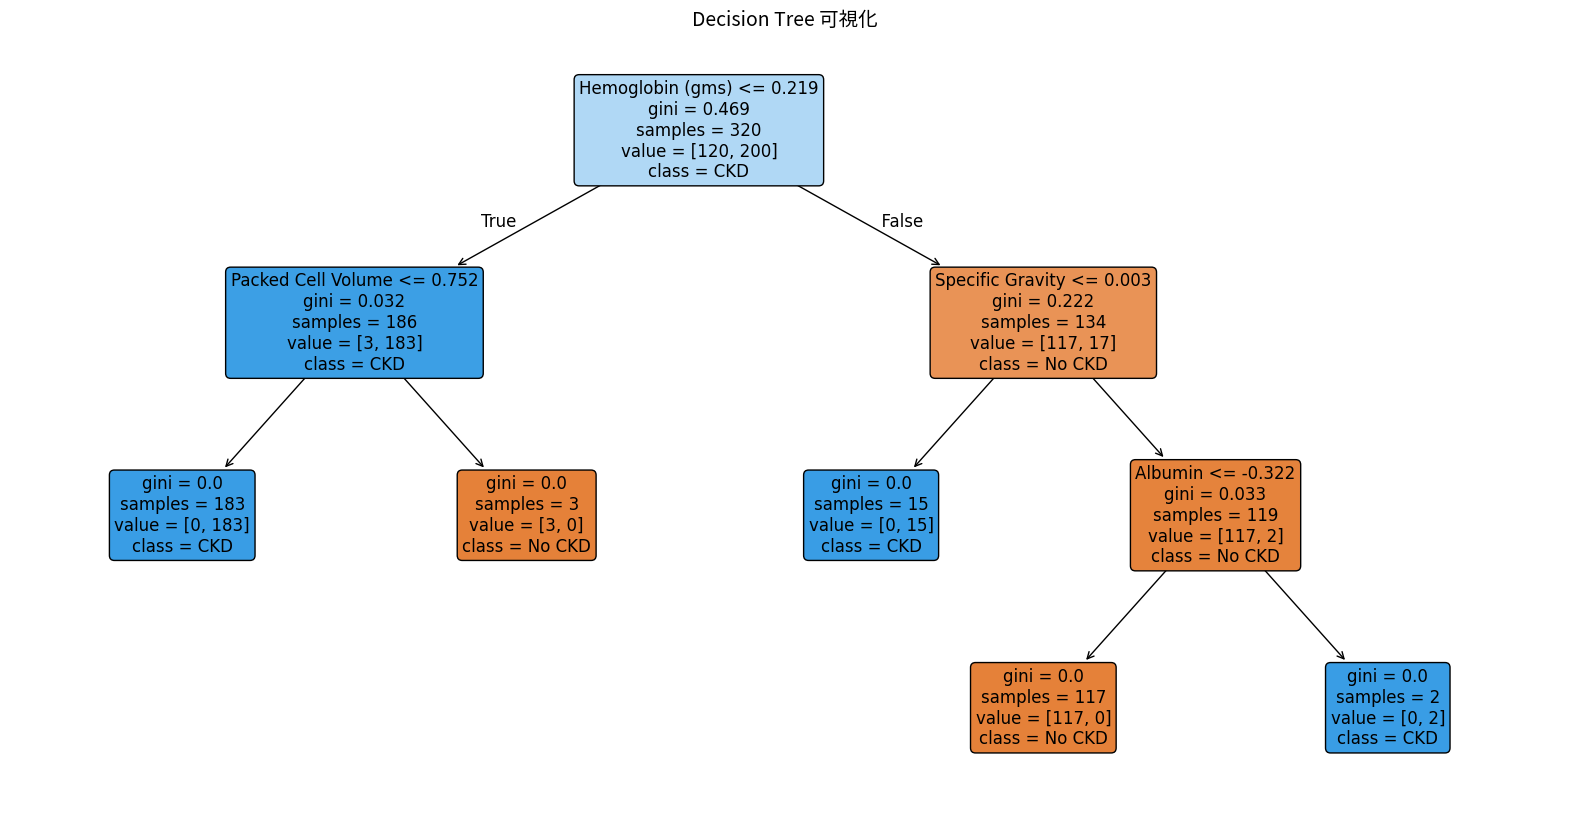

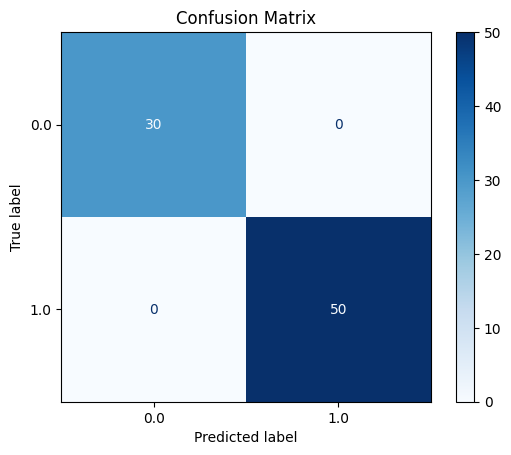

In [11]:
# === ROC 曲線圖 ===
plt.figure(figsize=(8, 6))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{name} (AUC = {data['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='隨機猜測')
plt.xlabel('假陽性率 (FPR)',fontproperties=font_prop)
plt.ylabel('真陽性率 (TPR)',fontproperties=font_prop)
plt.title('ROC 曲線比較',fontproperties=font_prop)
plt.legend(loc='lower right',prop=font_prop)
plt.grid(True)
plt.show()
# === 準確率 + AUC 長條圖 ===
labels = list(models.keys())
acc_vals = [accuracies[name] for name in labels]
auc_vals = [roc_data[name]['auc'] for name in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, acc_vals, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, auc_vals, width, label='AUC', color='lightgreen')

ax.set_ylabel('分數',fontproperties=font_prop)
ax.set_title('模型準確率與 AUC 比較',fontproperties=font_prop)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# 加上數值標籤
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.02,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#畫決策樹
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=['No CKD', 'CKD'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree 可視化",fontproperties=font_prop)
plt.show()



#預測與混淆矩陣
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

===================測試待整理===========================
